<a href="https://colab.research.google.com/github/NRiccieri/HIAAC_Project_Group3/blob/main/FL_proposta_algoritmo_compressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FL Compression Algorithm**

**Experiment parameters**

In [44]:
#FL environment parameters

num_clients = 35   #total number of devices in the FL environment
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = int(num_clients*percentage_clients_considered)
num_clients_selected = int(percentage_clients_selected*num_clients_considered)


#training parameters
num_iterations_per_round = 10 #number of iterations executed by clients at each round of the algorithm

max_num_rounds = 200

validation_size = 0.15

epsilon = 0.06 #difference between the trained FL global model accuracy score and the centralised model accuracy score

accuracy_score_target = 0.91

Note: In a centralized training, given the architecture used (3 hidden layers with 256 units), we reach an accuracy score of about 98.5% in 120 epochs.

The training time is 2 minutes 22 seconds.

**The accuracy on the testing data is 91%.**

## **Importing the dataset from Kaggle**

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
#create gdrive folder inside content
from google.colab import drive
drive.mount('/content/gdrive')

#importing dataset to google colab from gdrive
!cp /content/gdrive/MyDrive/kaggle_datasets/archive.zip  /content/archive.zip 

#unzipping 
!unzip archive.zip 

Mounted at /content/gdrive
Archive:  archive.zip
  inflating: test.csv                
  inflating: train.csv               


In [4]:
#train dataset that will be split between all clients
df_train = pd.read_csv('train.csv')

x_train = pd.DataFrame(df_train.drop(['Activity','subject'],axis=1))
y_train = df_train.Activity.values.astype(object)

#test dataset that will be located in central server
df_test = pd.read_csv('test.csv')

central_server_data_x = pd.DataFrame(df_test.drop(['Activity','subject'],axis=1))
central_server_data_y_true = df_test.Activity.values.astype(object)

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

encoder=preprocessing.LabelEncoder()

encoder.fit(y_train)
y_train = encoder.transform(y_train)
print(encoder.classes_)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

#scaling central server dataset
central_server_data_x = scaler.transform(central_server_data_x)
central_server_data_y_true = encoder.transform(central_server_data_y_true)

#creating the datasets
#x_test/y_test could be used by server to check gloabl model accuracy
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=100)

['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


## **Creating datasets for each client**

In [6]:
#returns an object with clientID as key, and its dataset
def returnDatasetPerClientObject(x, y):
  datasetObject = []

  n = x.shape[0]
  m = int(n/num_clients)

  i = 0
  while i < num_clients:
    client_i_x = x[ m * i :  m * (i + 1) ]
    client_i_y = y[ m * i :  m * (i + 1) ]
    datasetObject.append({"x": client_i_x, "y": client_i_y})
    i +=1

  return datasetObject


#returns the dataset x/y of a client
def returnDatasetForClient(clientid, datasetObject):
  return {"x" : datasetObject[clientid]["x"] , "y" : datasetObject[clientid]["y"]}


## **Machine learning model implementation**

**In TensorFlow**

**Functions in central server side**

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt


def returnInitialGlobalModel():

  model = Sequential([
      
      # reshape 28 row * 28 column data to 28*28 rows
      Flatten(input_shape=(561,), name="inputlayer"),
      
      # dense layer 1
      Dense(256, activation='sigmoid', name="firstlayer"),  
      
      # dense layer 2
      Dense(256, activation='sigmoid', name="secondlayer"), 

      # dense layer 3
      Dense(256, activation='sigmoid', name="thirdlayer"), 
      
      # output layer
      Dense(6, activation='sigmoid', name="outputlayer"),  
  ])

  model.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model


#returns a copy of the global model to client
def returnCopyGlobalModelToClient(globalmodel):

  clientmodel = returnInitialGlobalModel()
  clientmodel.set_weights(globalmodel.get_weights()) 

  return clientmodel


#function that returns the accuracy score of the global model on the client's data
def evaluateGlobalModel(globalmodel, x, y):
  
  results = globalmodel.evaluate(x, y)

  return results[1]


# #computes the average gradient from the sum of clients' gradient
# def returnAverageGradient(clientsgradientobject):
  
#   averagegradient = list()
#   for trained_client in clientsgradientobject:
#     averagegradient += trained_client.clientgradient
#     averagegradient = averagegradient / num_clients_selected

#   return averagegradient


#function that uncompresses the gradient from the clients
def uncompressClientsGradient(clientscompressedgradientobject):

  clientsUncompressedradientobject = clientscompressedgradientobject
  
  return clientsUncompressedradientobject


#update the central server model with the gradient from clients
def updateGlobalModelWeights(globalmodel, clientsgradientobject):

  for clientgradient in clientsgradientobject:
    i = 0
    for layer in globalmodel.layers:
      if i >= 1:
        j = 0
        for weight in layer.weights:
          current_weights = layer.weights[j]
          globalmodel.layers[i].weights[j] = current_weights - clientgradient["clientgradient"].layers[i].weights[j] / num_clients_selected
          j += 1
      i +=1

**Functions in clients side**

In [12]:
#returns the compressed gradient to be sent to central server
def compressGradient(clientgradient):
  
  compressedclientgradient = clientgradient
  return compressedclientgradient

#Given the weights after training and initial weights, returns the gradient from entire training
def computeClientGradient(modelNotTrained, modelTrained):
  gradient = []
  notTrainedWeight = modelNotTrained.get_weights()
  i = 0
  for weight in modelTrained.get_weights():
    gradient.append( notTrainedWeight[i] - weight )
    i += 1
  return gradient

def addGradient(modelNotTrained, gradient):
  newWeight = []
  i = 0
  notTrainedWeight = modelNotTrained.get_weights()
  for weight in modelNotTrained.get_weights():
    newWeight.append( weight - (gradient[i] / num_clients_selected) )
    i += 1
  modelNotTrained.set_weights(newWeight)

## **Central server logic implementation**

In [41]:
import random

#Generate a random list of clients considered of length num_clients_considered
def returnRandomSelectedClientsIDsList():
  return random.sample(range(0, num_clients_considered), num_clients_considered)


#function that returns the evaluation of the global model on the selected clients
def returnWorstLossesAmongChosenClients(classifierModel, chosenClients, datasetObject):
  
  clients_accuracy_list = [] #modelEvaluationObject()
  j = 0 
  
  #evaluate the classifier on each random client's data
  while j < len(chosenClients):
    
    client_id = chosenClients[j]
    client_dataset = returnDatasetForClient(client_id, datasetObject)
    client_accuracy_score = evaluateGlobalModel(classifierModel, client_dataset["x"], client_dataset["y"])
    
    clients_accuracy_list.append({"clientID": client_id, "accuracy": client_accuracy_score})

    j+= 1

  #order the losses from worst to best
  clients_accuracy_list.sort(key=lambda x: x["accuracy"], reverse=False)

  return clients_accuracy_list[:num_clients_selected]

#main code running on server side
def runTraining(classifierModel, accuracyScoreTarget, clientsDatasetObject):

  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  i = 0
  accuracy_score = 0
  per_round_global_model_accuracy = []

  while i < max_num_rounds:

      print("Round: ", i + 1, " / Max rounds:", max_num_rounds)
      
      #select random clients
      random_clients = returnRandomSelectedClientsIDsList()

      #return the list of clients with loss value from worst to best
      pretraining_loss_values_obj = returnWorstLossesAmongChosenClients(classifierModel, random_clients, clientsDatasetObject)

      print("Selected clients :", pretraining_loss_values_obj)

      selected_clients_grad_list = []
      
      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradient(classifierModel, client_model)
        
        #should compress the gradient before sending the client's gradient to central server
        compressed_client_gradient = compressGradient(client_gradient)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": compressed_client_gradient} )



      ##################
      #At central server
      ##################

      #uncompress the gradient from clients
      selected_clients_grad_list = uncompressClientsGradient(selected_clients_grad_list)

      #updating the global model weights
      #updateGlobalModelWeights(classifierModel, selected_clients_grad_list)
      for client_gradient in selected_clients_grad_list:
        addGradient(classifierModel, client_gradient["clientgradient"])

      #evaluating the global model on data contained in central server
      globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      per_round_global_model_accuracy.append(globalAccuracy)

      if globalAccuracy >= accuracyScoreTarget - epsilon:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        break

      print("Current global model accuracy score = ", globalAccuracy)
      print()

      i += 1

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per epoch')
  plt.show()


  return [classifierModel, per_round_global_model_accuracy]


## **Experiments**

93/93 [==============================] - 0s 2ms/step - loss: 1.9255 - accuracy: 0.1683
Starting
Before training global model accuracy = 0.16830675303936005

Round:  1  / Max rounds: 200
8/8 [==============================] - 0s 2ms/step - loss: 1.8264 - accuracy: 0.2327
Selected clients : [{'clientID': 7, 'accuracy': 0.10204081982374191}, {'clientID': 2, 'accuracy': 0.11020407825708389}, {'clientID': 4, 'accuracy': 0.11836734414100647}, {'clientID': 0, 'accuracy': 0.19183672964572906}]
93/93 [==============================] - 0s 2ms/step - loss: 1.7937 - accuracy: 0.1805
Current global model accuracy score =  0.18052256107330322

Round:  2  / Max rounds: 200
8/8 [==============================] - 0s 2ms/step - loss: 1.7390 - accuracy: 0.2367
Selected clients : [{'clientID': 8, 'accuracy': 0.1061224490404129}, {'clientID': 5, 'accuracy': 0.11428571492433548}, {'clientID': 3, 'accuracy': 0.11428571492433548}, {'clientID': 1, 'accuracy': 0.12653061747550964}]
93/93 [======================

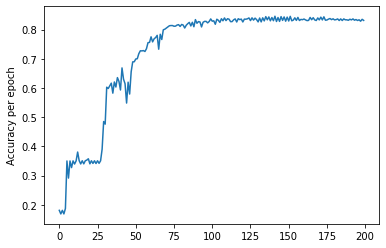

In [42]:
#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()

final_global_model, accuracy_history = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

93/93 [==============================] - 1s 2ms/step - loss: 1.9545 - accuracy: 0.1598
Starting
Before training global model accuracy = 0.15982355177402496

Round:  1  / Max rounds: 200
7/7 [==============================] - 0s 3ms/step - loss: 1.9978 - accuracy: 0.2143
Selected clients : [{'clientID': 0, 'accuracy': 0.12380952388048172}, {'clientID': 5, 'accuracy': 0.12380952388048172}, {'clientID': 1, 'accuracy': 0.12857143580913544}]
93/93 [==============================] - 0s 2ms/step - loss: 1.7853 - accuracy: 0.1683
Current global model accuracy score =  0.16830675303936005

Round:  2  / Max rounds: 200
7/7 [==============================] - 0s 3ms/step - loss: 1.8045 - accuracy: 0.1762
Selected clients : [{'clientID': 4, 'accuracy': 0.12380952388048172}, {'clientID': 6, 'accuracy': 0.1666666716337204}, {'clientID': 3, 'accuracy': 0.17619048058986664}]
93/93 [==============================] - 0s 2ms/step - loss: 1.7745 - accuracy: 0.2952
Current global model accuracy score =  0.2

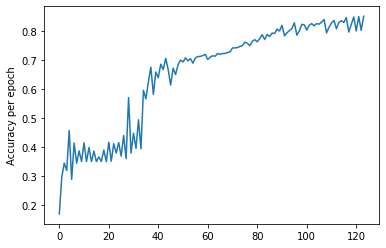

In [45]:
#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()

final_global_model, accuracy_history = runTraining(initial_global_model, accuracy_score_target , clients_dataset)